In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical

In [16]:
banca = pd.read_csv('bank-dataset.csv', encoding='latin-1', delimiter=';')
banca = banca.drop(['marital','education','contact','poutcome','day_of_week','month']
             ,axis=1)
banca = banca.dropna()
banca = banca.drop_duplicates()

Quitamos las columnas que hemos determinado que no aportan valor a los datos y solo ruido. Atendiendo a la página web donde se ha creado el dataset, el estado civil no nos parece aportar nada a si el cliente acepta la oferta o no, la educación no es relevante puesto que tenemos el trabajo del cliente, la manera de contactar no es útil, poutcome que es como han salido las anteriores ofertas tampoco es relevante y tanto los días de la semana como el mes solo introduciría ruido.
Cabe destacar que dependiendo del día o el mes es posible que algún cliente puntual cambie su decisión, pero como es algo extraordinario no lo tenemos en cuenta.

In [17]:
le = LabelEncoder()
banca['age'] = le.fit_transform(banca['age'])
banca['housing'] = le.fit_transform(banca['housing'])
banca['default'] = le.fit_transform(banca['default'])
banca['job'] = le.fit_transform(banca['job'])
banca['loan'] = le.fit_transform(banca['loan'])
banca['duration'] = le.fit_transform(banca['duration'])
banca['y'] = le.fit_transform(banca['y'])

In [18]:
banca.loc[(banca['age'] >= 0) & (banca['age'] <= 18), 'age'] = 0
banca.loc[(banca['age'] >= 19) & (banca['age'] <= 64), 'age'] = 1
banca.loc[(banca['age'] >= 65) & (banca['age'] <= 100), 'age'] = 2
count0 = len(banca[banca['y'] == 0])
count1 = len(banca[banca['y'] == 1])

# Imprimir el resultado
print("Hay", count0, "registros donde el valor en la columna es 0")
print("Hay", count1, "registros donde el valor en la columna es 1")

Hay 36521 registros donde el valor en la columna es 0
Hay 4639 registros donde el valor en la columna es 1


In [19]:
num_rows_to_remove = 31000
value_to_remove = 0
banca = banca.drop(banca[banca['y'] == value_to_remove].sample(n=num_rows_to_remove).index)
count0 = len(banca[banca['y'] == 0])
count1 = len(banca[banca['y'] == 1])

# Imprimir el resultado
print("Hay", count0, "registros donde el valor en la columna es 0")
print("Hay", count1, "registros donde el valor en la columna es 1")

Hay 5521 registros donde el valor en la columna es 0
Hay 4639 registros donde el valor en la columna es 1


Quitamos 31000 registros donde el valor de la columna de clase es 0, puesto que hay 36000 registros con clase 0 y tan solo 4000 con clase 1. Al quitar 31000 registros de clase 0, nuestro dataset está balanceado y es más óptimo para el entrenamiento.

Hacemos una discretización del valor de la edad y hacemos rangos con las edades para que sea más fácil para la red neuronal.

In [20]:
x = np.array(banca.iloc[:, :-1])
y = np.array(banca.iloc[:, -1])
X_train1, X_test, yEntrenar1, yTest = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_Val, yEntrenar, yValidar = train_test_split(X_train1, yEntrenar1, test_size=0.2, random_state=42)

In [21]:
#xEntrenar = to_categorical(X_train)
#xValidar = to_categorical(X_Val)
#xTest = to_categorical(X_test)
scaler = MinMaxScaler()
xEntrenar = scaler.fit_transform(X_train)
xValidar = scaler.fit_transform(X_Val)
xTest = scaler.fit_transform(X_test)

Epoch 1/1000
229/229 [==============================] - 2s 6ms/step - loss: 0.2302 - accuracy: 0.6010 - val_loss: 0.2227 - val_accuracy: 0.6386
Epoch 2/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.2203 - accuracy: 0.6540 - val_loss: 0.2142 - val_accuracy: 0.6725
Epoch 3/1000
229/229 [==============================] - 1s 4ms/step - loss: 0.2123 - accuracy: 0.6838 - val_loss: 0.2071 - val_accuracy: 0.6944
Epoch 4/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.2056 - accuracy: 0.7049 - val_loss: 0.2008 - val_accuracy: 0.7151
Epoch 5/1000
229/229 [==============================] - 1s 4ms/step - loss: 0.1996 - accuracy: 0.7229 - val_loss: 0.1949 - val_accuracy: 0.7283
Epoch 6/1000
229/229 [==============================] - 2s 8ms/step - loss: 0.1940 - accuracy: 0.7329 - val_loss: 0.1895 - val_accuracy: 0.7392
Epoch 7/1000
229/229 [==============================] - 2s 8ms/step - loss: 0.1887 - accuracy: 0.7381 - val_loss: 0.1845 - val_accuracy:

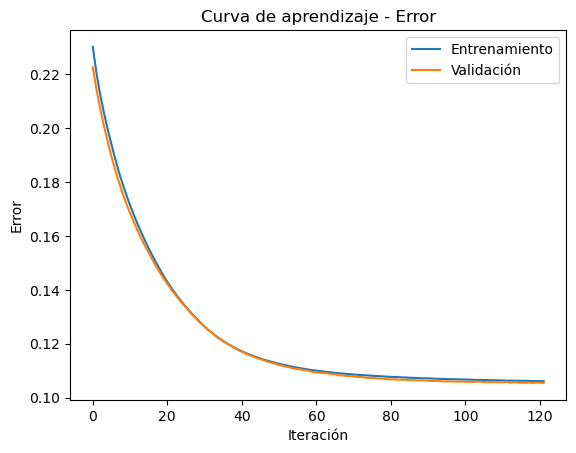

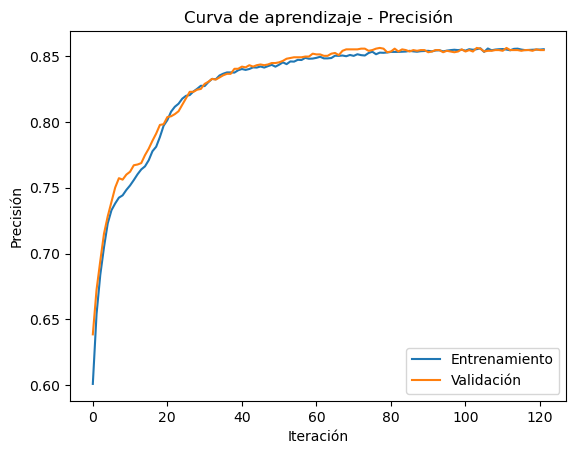

32/32 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.8514
Loss:  0.10982812196016312
Accuracy:  0.8513779640197754


In [22]:
# Definir el modelo
model = Sequential()
model.add(Dense(20, input_dim=14, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

# Definir EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Entrenar el modelo
history = model.fit(xEntrenar, yEntrenar, epochs=1000, batch_size=32, validation_data=(xValidar, yValidar), callbacks=[early_stop])

# Crear gráfica de error
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curva de aprendizaje - Error')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.legend()
plt.show()

# Crear gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curva de aprendizaje - Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Evaluarlo con los datos de test
loss, accuracy = model.evaluate(xTest, yTest)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [23]:
# Obtener los pesos del modelo
weights = model.get_weights()

# Calcular la importancia de las variables de entrada
importance = np.sum(np.abs(weights[0]), axis=1)

# Imprimir la importancia de las variables de entrada
print(importance)
print("Las columnas:", banca.columns[5], banca.columns[7], banca.columns[9], banca.columns[12], ", son las más influyentes")

[ 4.30665    3.4149497  4.3694663  3.4053953  3.6844325 17.924635
  4.420212   4.821999   5.2527256  5.646146   4.5247054  4.288524
  4.5825863  4.185743 ]
Las columnas: duration pdays emp.var.rate euribor3m , son las más influyentes


In [24]:
def color_map(value, cm):
    if value >= cm[0][0]:
        return 'red'
    else:
        return 'green'

32/32 [==============================] - 0s 3ms/step


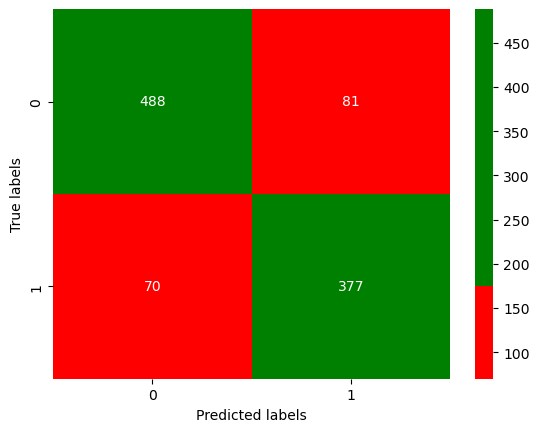

In [25]:
Predicciones = model.predict(xTest)
yPredicciones = np.array([1 if x > 0.5 else 0 for x in Predicciones])
cm = confusion_matrix(yTest, yPredicciones)
sns.heatmap(cm, annot=True, cmap=sns.color_palette([color_map(x, cm) for x in cm.flatten()]), fmt='d')

# Añadir etiquetas
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [26]:
precision = cm[0][0]/(cm[0][0]+cm[0][1])
especificidad = cm[1][1]/(cm[1][1]+cm[1][0])
sensibilidad = cm[0][0]/(cm[0][0]+cm[1][0])
exactitud = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Precisión: ", precision)
print("Especificidad: ", especificidad)
print("Sensibilidad: ", sensibilidad)
print("Exactitud: ", exactitud)

Precisión:  0.8576449912126538
Especificidad:  0.843400447427293
Sensibilidad:  0.8745519713261649
Exactitud:  0.8513779527559056
